In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
#import miceforest as mf
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

scaler = MinMaxScaler()
le = LabelEncoder()
lr = LinearRegression()

#補值-knn
def knn_filled_func(x_train, y_train, test, k=3, dispersed=True):
    if dispersed:
        rf = RandomForestRegressor()
    else:
        rf = RandomForestClassifier()
    rf.fit(x_train, y_train)
    return rf.predict(test)

#df補值-knn
def df_imputation():
    imputation = df[['day', 'targeted_productivity','smv', 'wip', 'over_time', 'incentive', 'no_of_workers', 'actual_productivity']]
    known = imputation[imputation.wip.notnull()]
    unknown = imputation[imputation.wip.isnull()] 
    x_train_pre = known[['day','smv', 'over_time','no_of_workers']]
    y_train_pre = known['wip']
    test_pre = unknown[['day','smv', 'over_time','no_of_workers']]
    x_train = x_train_pre.values
    x_train = x_train.tolist()
    y_train = y_train_pre.values
    y_train = y_train.tolist()
    test = test_pre.values
    test = test.tolist()
    na_index_list = df.index[df['wip'].isnull()].tolist()
    predict = knn_filled_func(x_train, y_train, test, k=3, dispersed=True)
    for i in range(0,len(na_index_list)):
        df.loc[na_index_list[i], 'wip'] = int (predict[i])
    df.to_csv('train_rfr.csv')
    
#df_test補值-knn
def df_test_imputation():
    imputation = df_test[['day', 'targeted_productivity','smv', 'wip', 'over_time', 'incentive', 'no_of_workers']]
    known = imputation[imputation.wip.notnull()]
    unknown = imputation[imputation.wip.isnull()] 
    x_test_pre = known[['day','smv', 'over_time','no_of_workers', 'targeted_productivity']]
    y_test_pre = known['wip']
    test_pre_test = unknown[['day','smv', 'over_time','no_of_workers', 'targeted_productivity']]
    x_test = x_test_pre.values
    x_test = x_test.tolist()
    y_test = y_test_pre.values
    y_test = y_test.tolist()
    test = test_pre_test.values
    test = test.tolist()
    na_index_list = df_test.index[df_test['wip'].isnull()].tolist()
    predict = knn_filled_func(x_test, y_test, test, k=3, dispersed=True)
    for i in range(0,len(na_index_list)):
        df_test.loc[na_index_list[i], 'wip'] = int (predict[i])
    df_test.to_csv('test_rfr.csv')

#df補值-regression
def df_regression():
    imputation = df[['day', 'targeted_productivity','smv', 'wip', 'over_time', 'incentive', 'no_of_workers','actual_productivity']]
    known = imputation[imputation.wip.notnull()]
    unknown = imputation[imputation.wip.isnull()] 
    x_train_pre = known[['smv']]
    y_train_pre = known['wip']
    test_pre = unknown[['smv']]
    x_train = x_train_pre.values
    x_train = x_train.tolist()
    y_train = y_train_pre.values
    y_train = y_train.tolist()
    test = test_pre.values
    test = test.tolist()
    lr.fit(x_train,y_train)
    predict = lr.predict(test)
    na_index_list = df.index[df['wip'].isnull()].tolist()
    for i in range(0,len(na_index_list)):
        df.loc[na_index_list[i], 'wip'] = int (predict[i])
        df.loc[na_index_list[i], 'incentive'] = int (df['incentive'].mean())
    df.to_csv('train_regression.csv')
    
def df_test_regression():
    imputation = df_test[['day', 'targeted_productivity','smv', 'wip', 'over_time', 'incentive', 'no_of_workers']]
    known = imputation[imputation.wip.notnull()]
    unknown = imputation[imputation.wip.isnull()] 
    x_test_pre = known[['smv']]
    y_test_pre = known['wip']
    test_pre_test = unknown[['smv']]
    x_test = x_test_pre.values
    x_test = x_test.tolist()
    y_test = y_test_pre.values
    y_test = y_test.tolist()
    test = test_pre_test.values
    test = test.tolist()
    lr.fit(x_test,y_test)
    predict = lr.predict(test)
    na_index_list = df_test.index[df_test['wip'].isnull()].tolist()
    for i in range(0,len(na_index_list)):
        df_test.loc[na_index_list[i], 'wip'] = int (predict[i])
        df_test.loc[na_index_list[i], 'incentive'] = int (df_test['incentive'].mean())
    df_test.to_csv('test_regression.csv')

#調參
def trainandTest(X_train, y_train, X_test):
    # XGBoost訓練過程
    model = XGBRegressor(max_depth=6, learning_rate=0.05, n_estimators=500, silent=False, objective='reg:gamma')
    model.fit(X_train, y_train)
    # 對測試集進行預測
    ans = model.predict(X_test)
    ans_len = len(ans)
    id_list = np.arange(10441, 17441)
    data_arr = []
    for row in range(0, ans_len):
        data_arr.append([int(id_list[row]), ans[row]])
        np_data = np.array(data_arr)
    # 顯示重要特徵
    plot_importance(model)
    plt.show()

#Scatter plot for var1/var2
def scatter_plot(var1, var2):
    data = pd.concat([df[var1], df[var2]], axis=1)
    data.plot.scatter(x=var1, y=var2)

In [28]:
df = pd.read_csv(r'./train.csv')
df['date'] = le.fit_transform(df['date'])
df['quarter'] = le.fit_transform(df['quarter'])
df['department'] = le.fit_transform(df['department'])
df['day'] = le.fit_transform(df['day'])
# df = df.drop('date', axis = 1)
# df = df.drop('quarter', axis = 1)
# df = df.drop('department', axis = 1)
# df = df.drop('day', axis = 1)
# df = df.drop('wip', axis = 1)
# df = df.drop('idle_time', axis = 1)
# df = df.drop('idle_men', axis = 1)
# df = df.drop('no_of_style_change', axis = 1)
# df_imputation()
df_regression()
X = df[df.columns[0:-1]]
y = df[df.columns[-1]]
X_scaled = scaler.fit_transform(X)

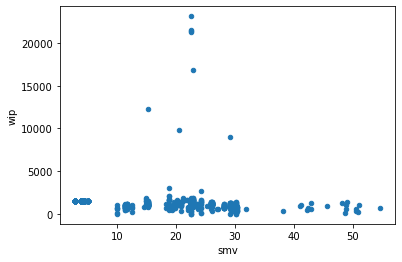

In [29]:
var1 = 'smv'
var2 = 'wip'
scatter_plot(var1, var2)

In [30]:
# model = XGBRegressor(learning_rate=0.01, gamma=0.01, reg_alpha=0.1, reg_lambda=0.1, max_depth=5, min_child_weight=6,
#                subsample=1, colsample_bytree=0.9, n_estimators=580, n_jobs=1)
# model = XGBRegressor(n_estimators=580)
# model = XGBRegressor(learning_rate=0.01,n_estimators=400,n_jobs=1,min_child_weight=5)
model = XGBRegressor(n_estimators=90,objective='reg:squarederror')
model.fit(X,y)

C:\Users\Wynns\anaconda3\envs\workspace\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=90, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [31]:
df_test = pd.read_csv(r'./test.csv')
df_test['date'] = le.fit_transform(df_test['date'])
df_test['quarter'] = le.fit_transform(df_test['quarter'])
df_test['department'] = le.fit_transform(df_test['department'])
df_test['day'] = le.fit_transform(df_test['day'])
# df_test = df_test.drop('date', axis = 1)
# df_test = df_test.drop('quarter', axis = 1)
# df_test = df_test.drop('department', axis = 1)
# df_test = df_test.drop('day', axis = 1)
# df_test = df_test.drop('wip', axis = 1)
# df_test = df_test.drop('idle_time', axis = 1)
# df_test = df_test.drop('idle_men', axis = 1)
# df_test = df_test.drop('no_of_style_change', axis = 1)
# df_test_imputation()
df_test_regression()
X_test = df_test[df_test.columns]
X_test_scaled = scaler.fit_transform(X_test)
y_pred = model.predict(X_test_scaled)

R2: 0.97 (std: 0.02)
[0.9756439  0.97592582 0.9977446  0.96801429 0.92552982]


C:\Users\Wynns\anaconda3\envs\workspace\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Wynns\anaconda3\envs\workspace\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Wynns\anaconda3\envs\workspace\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\Wynns\anaconda3\envs\workspace\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Ind

R2: 0.9685716862692242 (std: 0.02369840366670562)
MSE: 0.0001343332427495625 (std: 7.633011299213925e-05)
MAPE: 0.013431997643783689 (std: 0.005751642982101193)
MAE: 0.009472387935966253 (std: 0.004079470370917238)


C:\Users\Wynns\anaconda3\envs\workspace\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


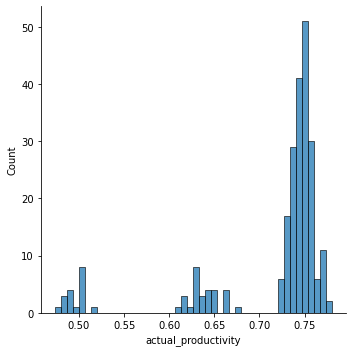

In [33]:
df_ans = pd.DataFrame(y_pred.astype(float), columns=['actual_productivity'])
df_ans.to_csv('mySubmission.csv', index_label='Id')
df = pd.read_csv(r'./mySubmission.csv')
sns.displot(df['actual_productivity'])

scores = cross_val_score(model, X_test_scaled, y_pred, cv=5)
print("R2: %0.2f (std: %0.2f)" % (scores.mean(), scores.std()))
print(scores)
# need other scoring
scores = cross_validate(model, X_test, y_pred, cv=5, scoring=('r2', 'neg_mean_squared_error', 'neg_mean_absolute_percentage_error', 'neg_mean_absolute_error'))
print("====================================")
print("R2: {} (std: {})".format(scores['test_r2'].mean(), scores['test_r2'].std()))
print("MSE: {} (std: {})".format(-scores['test_neg_mean_squared_error'].mean(), scores['test_neg_mean_squared_error'].std()))
print("MAPE: {} (std: {})".format(-scores['test_neg_mean_absolute_percentage_error'].mean(), scores['test_neg_mean_absolute_percentage_error'].std()))
print("MAE: {} (std: {})".format(-scores['test_neg_mean_absolute_error'].mean(), scores['test_neg_mean_absolute_error'].std()))

In [ ]:
# trainandTest(X, y, X_test)

In [ ]:
#調參
# cv_params = {'min_child_weight':[3,4,5]}
# # other_params = {'learning_rate':0.01, 'gamma':0.01, 'reg_alpha':0.1, 'reg_lambda':0.1, 'max_depth':5, 'min_child_weight':6,
# #                 'subsample':1, 'colsample_bytree':0.9, 'n_estimators':580, 'n_jobs':1}
# other_params = {'learning_rate':0.01,'n_estimators':400, 'n_jobs':1,'min_child_weight':5}
# model = XGBRegressor(**other_params)
# optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)
# optimized_GBM.fit(X, y)
# evalute_result = optimized_GBM.cv_results_
# print('每輪迭代運行結果', (evalute_result))
# print('參數的最佳取值', (optimized_GBM.best_params_))
# print('最佳模型得分', (optimized_GBM.best_score_))